In [1]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
warnings.filterwarnings('ignore')

# For vectorization and modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# For ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Provide dataset filenames (in the same folder)
fake_path = "fake.csv"
true_path = "original.csv"

# Load the datasets
fake_news = pd.read_csv(fake_path)
true_news = pd.read_csv(true_path)

# Add a label column: 1 for true, 0 for fake
true_news["label"] = 1
fake_news["label"] = 0

# Combine both datasets
df = pd.concat([true_news, fake_news], axis=0).reset_index(drop=True)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Display first 5 rows
df.head()


,Unnamed: 0,text,label
0,243,"Dennis Lloyd Mothersbaugh, 37, has a long and ...",0
1,15362,THIS WAS A VERY AWKWARD MOMENT BUT THE BEST PA...,0
2,480,The U.S. Senate will vote later Wednesday on w...,1
3,10797,President Barack Obama does plan to sign a Nor...,1
4,32588,Veterans Affairs Secretary Robert McDonald apo...,1


In [2]:
# Data preprocessing

# Show column names and unique values to identify label column
print("Columns:", df.columns)
print("\nUnique labels:", df[df.columns[-1]].unique())

# Rename label column to "label" for consistency
df = df.rename(columns={df.columns[-1]: "label"})

# Convert labels to numeric if needed (e.g., "FAKE" → 0, "REAL" → 1)
if df["label"].dtype == object:
    df["label"] = df["label"].map({"FAKE": 0, "REAL": 1, "fake": 0, "true": 1, "TRUE": 1, "FALSE": 0})

# Drop rows with missing values (if any)
df.dropna(inplace=True)

# Combine title + text if both exist
if "title" in df.columns and "text" in df.columns:
    df["content"] = df["title"] + " " + df["text"]
elif "text" in df.columns:
    df["content"] = df["text"]
elif "article" in df.columns:
    df["content"] = df["article"]

# Lowercase + remove punctuation
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

df["content"] = df["content"].apply(clean_text)

# Preview cleaned data
df[["content", "label"]].head()


Columns: Index(['Unnamed: 0', 'text', 'label'], dtype='object')

Unique labels: [0 1]


,content,label
0,dennis lloyd mothersbaugh 37 has a long and vi...,0
1,this was a very awkward moment but the best pa...,0
2,the us senate will vote later wednesday on whe...,1
3,president barack obama does plan to sign a nor...,1
4,veterans affairs secretary robert mcdonald apo...,1


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Step 3: TF-IDF vectorization

# Separate features and labels
X = df["content"]
y = df["label"]

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Show the shape of vectorized data
print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)


Train shape: (62870, 334914)
Test shape: (15718, 334914)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train and evaluate multiple models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\n🔷 {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



🔷 Logistic Regression
Accuracy: 0.9481
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      8698
           1       0.95      0.93      0.94      7020

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718


🔷 Support Vector Machine
Accuracy: 0.9633
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      8698
           1       0.97      0.95      0.96      7020

    accuracy                           0.96     15718
   macro avg       0.96      0.96      0.96     15718
weighted avg       0.96      0.96      0.96     15718


🔷 Random Forest
Accuracy: 0.9406
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8698
           1       0.94      0.92      0.93      7020

    accuracy                           0.94     15718
   macro av

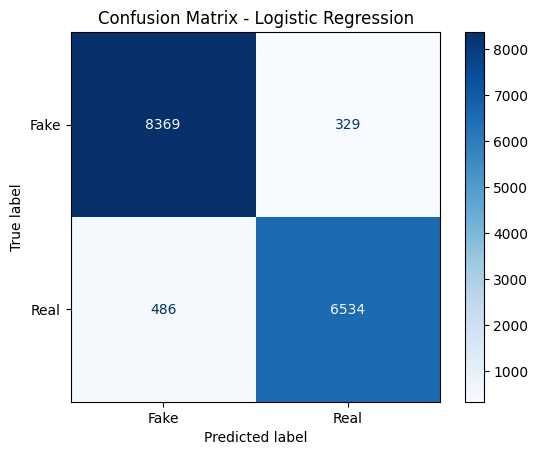

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

#  Confusion Matrix for Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred = lr_model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


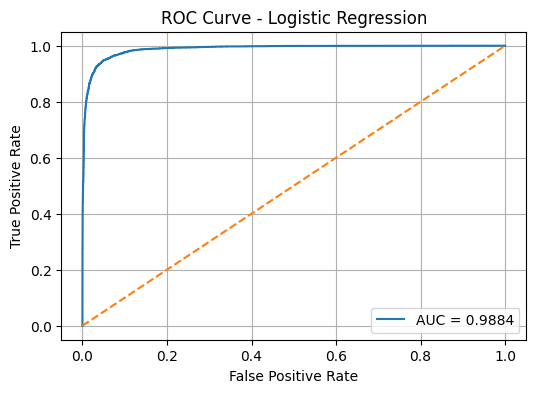

In [6]:
#  ROC Curve
y_prob = lr_model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_score:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid()
plt.show()


In [7]:
import joblib

#  Save model and vectorizer
joblib.dump(lr_model, "fake_news_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!


In [ ]:
# Load model and vectorizer for prediction
import joblib

# Load saved model and vectorizer
model = joblib.load("fake_news_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Predict function
def predict_news(text):
    cleaned = re.sub(r"[^\w\s]", "", text.lower())
    vect_text = vectorizer.transform([cleaned])
    prediction = model.predict(vect_text)[0]
    label = "REAL" if prediction == 1 else "FAKE"
    return label

# Test on a sample input
sample = "Breaking: Government launches new AI pol"
print(f"News: {sample}")
print("Prediction:", predict_news(sample))


News: Breaking: Government launches new AI policy for education sector
Prediction: FAKE
